# Homework 2: Discover the genetic basis of poplar tree adaptation to climate zones

## Step 0. Information about this project.

> **Author**:
>- `Weiyuan Xu`

> **Objective**: 
> - This project is designed to discover `genotypes` associated with `the minimum annual temperature` and `average cloud density`. 

## Step 1. Load in Packages & Data Sets.

### 1-1. Load in packages.

In [7]:
import pandas as pd
import numpy as np
from os.path import join as oj
import datatable as dt
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.inspection import permutation_importance


### 1-2. Load in data sets

#### 1-2-1. SNP data (Feature data set)

In [8]:
DATA_DIR = oj("..", "..", "VSCode", "STAT 154")

In [9]:
snp_orig_dt = dt.fread(oj(DATA_DIR, "869_NoCal_CR0.99.tagSNPs_BigLD0.70.txt"))

In [10]:
snp_orig_dt.shape

(869, 786075)

In [11]:
snp_orig_dt[:, :10].head()

,FID,IID,PAT,MAT,SEX,PHENOTYPE,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A
,▪▪▪▪,▪▪▪▪,▪,▪,▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪,▪▪▪▪
0,BESC-418,BESC-418,0,0,0,−9,1,2,2,2
1,BESC-52,BESC-52,0,0,0,−9,2,1,2,2
2,BESC-79,BESC-79,0,0,0,−9,2,1,NA,2
3,BESC-246,BESC-246,0,0,0,−9,NA,NA,2,2
4,BESC-313,BESC-313,0,0,0,−9,2,1,2,1
5,BESC-460,BESC-460,0,0,0,−9,2,0,2,2
6,GW-10958,GW-10958,0,0,0,−9,2,1,2,2
7,DENA-17-3,DENA-17-3,0,0,0,−9,2,0,2,2
8,VNDL-27-4,VNDL-27-4,0,0,0,−9,2,0,2,2


In [12]:
del snp_orig_dt[:, ["FID", "IID", "PAT", "MAT", "SEX", "PHENOTYPE"]]

In [13]:
snp_orig = snp_orig_dt.to_pandas()

In [14]:
snp_orig.iloc[:, :10].head()

,Chr01_8003_G,Chr01_11528_T,Chr01_13272_G,Chr01_20328_A,Chr01_21912_G,Chr01_21933_G,Chr01_28782_A,Chr01_29115_A,Chr01_34179_G,Chr01_35036_A
0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2,2.0,1
1,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2,1.0,1
2,2.0,1.0,NaN,2.0,2.0,1.0,1.0,2,2.0,1
3,NaN,NaN,2.0,2.0,2.0,1.0,2.0,1,2.0,2
4,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1,2.0,1


#### 1-2-2. Average cloud density and Minimum annual temperature data (Response data sets) 

In [15]:
cloud_dens_orig = pd.read_csv(oj(DATA_DIR, "cloud_dens_yearAvg"), sep="\t", header=None)
tmin_orig = pd.read_csv(oj(DATA_DIR, "tmin_yearAvg"), sep="\t", header=None)

In [16]:
cloud_dens_orig.shape

(869, 3)

In [17]:
cloud_dens_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.693175
1,BESC-52,BESC-52,-0.025059
2,BESC-79,BESC-79,0.151925
3,BESC-246,BESC-246,-0.929824
4,BESC-313,BESC-313,-0.689698


In [18]:
tmin_orig.shape

(869, 3)

In [19]:
tmin_orig.head()

,0,1,2
0,BESC-418,BESC-418,0.377185
1,BESC-52,BESC-52,0.391660
2,BESC-79,BESC-79,0.490293
3,BESC-246,BESC-246,0.080623
4,BESC-313,BESC-313,0.467125


#### 1-2-3 Check Alignment of Response data sets.

In [20]:
print(tmin_orig[0].equals(cloud_dens_orig[0]))

True


## Step 2. Data Cleaning.

### 2-1. Clear the memory of `snp_orig_dt` to save memory.

`Interpretation for clearing the variable memory` \
Since `snp_orig_dt` variable costs about 8 GB memory and it will not been used in the following steps \
(We have Pandas Dataframe `snp_orig` instead) \
we clear this variable in order to make the following codes run efficiently.

In [21]:
del snp_orig_dt

### 2-2. Implement Feature Sampling in our feature data set.

`Interpretation for implementing feature sampling before modeling` \
Since the number of features in our original feature data set is about 786069, however, we have just 869 observation, which means that our data set is ultra-high dimensional. \
**If we directly implement regularized machine learning model on this unsampled feature data set, then the implementation duration will be extremely long!** \
(even if we sample 8000 features, it will also cost 120 minites to implement the machine learning models, which is quite time-expensive!) \
So, to keep our designed model / designed project running efficiently, we cut down the feature size to **3000** via feature sampling.

In [22]:
X = snp_orig.sample(n=3000, axis=1)
X.shape
X1_Minimum_Temperature = X
X2_Average_Cloud_Density = X

### 2-3. Extract the responses from our response data sets.

In [23]:
y1_Minimum_Temperature = tmin_orig[2]
y2_Average_Cloud_Density = cloud_dens_orig[2]

### 2-4. Get rid of samples with y = NA.

`Interpretation for getting rid of samples with y = NA` \
Since we cannot impute the value of responses as we do to the value of features, we have to drop the observations in feature data set and response data set\
whose response value is null.

In [24]:
X1_Minimum_Temperature = X1_Minimum_Temperature[~y1_Minimum_Temperature.isna()]
y1_Minimum_Temperature = y1_Minimum_Temperature[~y1_Minimum_Temperature.isna()]

X2_Average_Cloud_Density = X2_Average_Cloud_Density[~y2_Average_Cloud_Density.isna()]
y2_Average_Cloud_Density = y2_Average_Cloud_Density[~y2_Average_Cloud_Density.isna()]

After getting rid of samples with `y1_Minimum_Temperature` = NA \
the remaining sample size is 787 for predicting Minimum_Temperature.

In [25]:
X1_Minimum_Temperature.shape, y1_Minimum_Temperature.shape

((787, 3000), (787,))

After getting rid of samples with `y2_Average_Cloud_Density` = NA \
the remaining sample size is 869 for predicting Minimum_Temperature. \
*It means that there is no null value in `y2_Average_Cloud_Density`.*

In [26]:
X2_Average_Cloud_Density.shape, y2_Average_Cloud_Density.shape

((869, 3000), (869,))

## Step 3: Exploratory Data Analysis.

### 3-1. EDA For Prediction Task 1 (Genotypes vs Minimum Temperature)

#### 3-1-1 Feature analysis: The distribution of genotypes values

`Interpretation for the distribution of genotypes values` \
It is well noticed that the distribution of genotypes values is highly non-uniform,\
the trend is that when the value of genotype is higher, then the corresponding frequency is higher. 

In [27]:
X1_frequency_0 = (X1_Minimum_Temperature.values == 0).sum()
X1_frequency_1 = (X1_Minimum_Temperature.values == 1).sum()
X1_frequency_2 = (X1_Minimum_Temperature.values == 2).sum()

distribution_data_X1 = {'Genotypes Value': [0, 1, 2],
        'Frequency': [X1_frequency_0, X1_frequency_1, X1_frequency_2]}

df_distribution_X1 = pd.DataFrame(distribution_data_X1)

df_distribution_X1

,Genotypes Value,Frequency
0,0,143756
1,1,644557
2,2,1568214


#### 3-1-2 Feature analysis: The correlations of genotypes values

`Interpretation for the correlation of genotypes values` \
It is well noticed that some of the genotypes values are highly correlated\
(When the corresponding color is nearly blue in our heatmap),\
however, most of the correlations are not that large.

<AxesSubplot:>

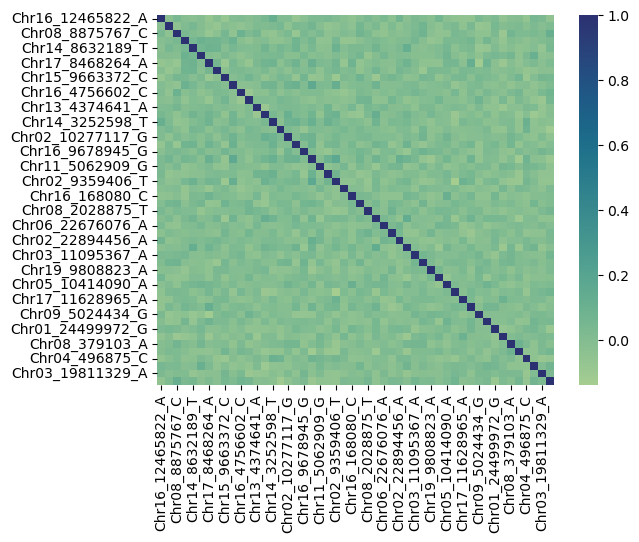

In [28]:
correlation_X1 = X1_Minimum_Temperature.sample(n = 50, axis = 1)
corr_matrix_X1 = correlation_X1.corr()
sns.heatmap(corr_matrix_X1, cmap="crest")

#### 3-1-3 Response analysis: The distribution of Minimum Temperature

`Interpretation for the distribution of minimum temperature` \
It is well noticed that the value of minimum temperature is highly concentrated on [0, 0.5]

/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2'>

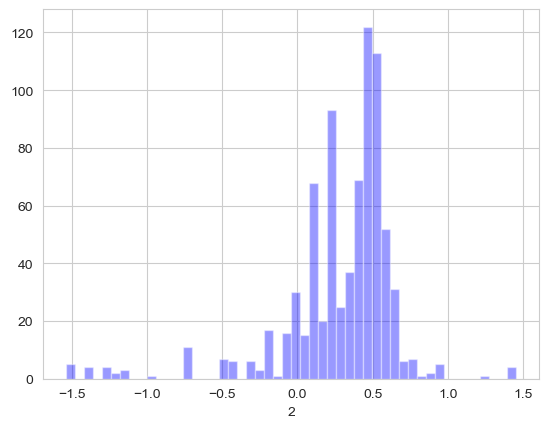

In [29]:
sns.set_style('whitegrid')
sns.distplot(y1_Minimum_Temperature, kde = False, color ='blue', bins = 50)

### 3-2. EDA For Prediction Task 2 (Genotypes vs Average Cloud Density)

#### 3-2-1 Feature analysis: The distribution of genotypes values

`Interpretation for the distribution of genotypes values` \
It is well noticed that the distribution of genotypes values is highly non-uniform,\
the trend is that when the value of genotype is higher, then the corresponding frequency is higher. 

In [30]:
X2_frequency_0 = (X2_Average_Cloud_Density.values == 0).sum()
X2_frequency_1 = (X2_Average_Cloud_Density.values == 1).sum()
X2_frequency_2 = (X2_Average_Cloud_Density.values == 2).sum()

distribution_data_X2 = {'Genotypes Value': [0, 1, 2],
        'Frequency': [X2_frequency_0, X2_frequency_1, X2_frequency_2]}

df_distribution_X2 = pd.DataFrame(distribution_data_X2)

df_distribution_X2

,Genotypes Value,Frequency
0,0,159690
1,1,710238
2,2,1732110


#### 3-2-2 Feature analysis: The correlations of genotypes values

`Interpretation for the correlation of genotypes values` \
It is well noticed that some of the genotypes values are highly correlated\
(When the corresponding color is nearly purple in our heatmap),\
however, most of the correlations are not that large.

<AxesSubplot:>

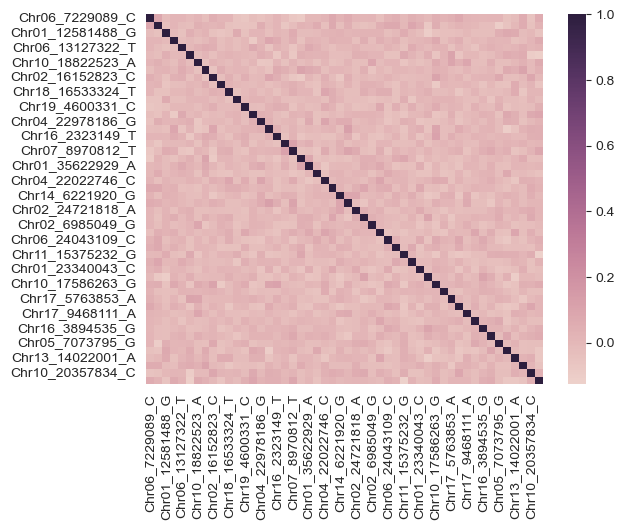

In [31]:
correlation_X2 = X2_Average_Cloud_Density.sample(n = 50, axis = 1)
corr_matrix_X2 = correlation_X2.corr()
sns.heatmap(corr_matrix_X2, cmap=sns.cubehelix_palette(as_cmap=True))

#### 3-2-3 Response analysis: The distribution of Average Cloud Density

`Interpretation for the distribution of average cloud density` \
It is well noticed that the value of average cloud density is highly concentrated on [-1, 1]

/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='2'>

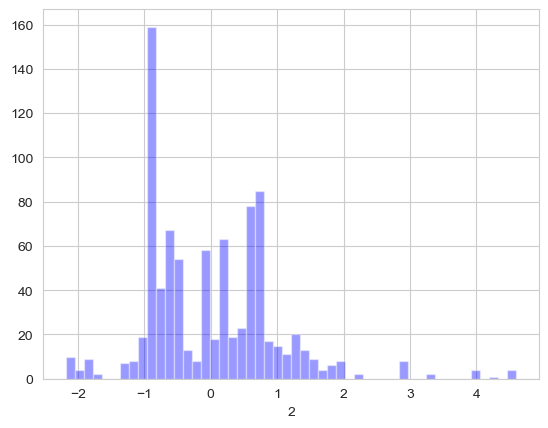

In [32]:
sns.set_style('whitegrid')
sns.distplot(y2_Average_Cloud_Density, kde = False, color ='blue', bins = 50)

## Step 4: Machine Learning Models Implementations.

### 4-1. Model Designing

#### 4-1-1. Model Selection

For each of two prediction tasks, we are going to implement the following three machine learning models, and then compare and select the best one:
- **Random Forest**: Random Forest does not assume the shape of data, and it is robust to feature interaction (handle the correlation between the values of genotype well that we mentioned in our EDA part), so we pick Random Forest as the first candidate model;
- **Lasso**: Lasso takes L1-Norm Penalty, which will make our model sparse, and also benefit the interpretability (Fewer features, higher interpretability), so we pick Lasso as the second candidate model;
- **Ridge**: Ridge takes L2-Norm Penalty, which will make our model shrink, then better handle the high-dimensional data, so we pick Ridge as the third candidate model.

#### 4-1-2. Data Splitting

`Interpretation for data splitting` \
The following data splitting split the data into:
- **80% : Training + Validation set** (among them, 80% is for training and 20% is for validation)
- **20% : Testing set**

The splitting percentage is a **bias-variance tradeoff**:
- When the percentage for (training + validation) is too small: Reduce variance but increase bias;
- When the percentage for (training + validation) is too large: Reduce the bias but increase variance.

In [33]:
# Split the whole data set into (training + validation) and testing set.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_Minimum_Temperature, y1_Minimum_Temperature, test_size=0.2, random_state=1234)
# Split the training data set into training and validation set.
X1_train, X1_valid, y1_train, y1_valid = train_test_split(X1_train, y1_train, test_size=0.2, random_state=331)

In [34]:
X1_train.shape, y1_train.shape, X1_valid.shape, y1_valid.shape, X1_test.shape, y1_test.shape

((503, 3000), (503,), (126, 3000), (126,), (158, 3000), (158,))

In [35]:
# Split the whole data set into (training + validation) and testing set.
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_Average_Cloud_Density, y2_Average_Cloud_Density, test_size=0.2, random_state=1234)
# Split the training data set into training and validation set.
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2_train, y2_train, test_size=0.2, random_state=331)

In [36]:
X2_train.shape, y2_train.shape, X2_valid.shape, y2_valid.shape, X2_test.shape, y2_test.shape

((556, 3000), (556,), (139, 3000), (139,), (174, 3000), (174,))

#### 4-1-3. Null Value Imputing

We consider two classic types of imputing methods in this project:
- **SimpleImputer**: Impute the missing values with some summary statistics such as mean, median, mode; 
- **KNNImputer**: Impute the missing values by the mean value from n_neighbors nearest neighbors in KNN model;

#### 4-1-4. Cross Validation

There are some hyperparameters of machine learning models and imputers that we need to tune:
- **Minimum of Sample in Leaf - Random Forest** 
- **Alpha - Lasso** 
- **Alpha - Ridge** 
- **N Neighbors - KNN Imputer** 

Here, we design the cross-validation to tune the hyperparameters.

#### 4-1-5. Overall Pipeline Designing

In [37]:
imputers = {
    "simple_imputer": SimpleImputer(strategy="most_frequent"),
    "knn_imputer": KNNImputer()
}
models = {
    "rf": RandomForestRegressor(n_estimators=100, min_samples_leaf=5),
    "lasso": Lasso(),
    "ridge": Ridge()
}
cv_param_grid_all = {
    "rf__min_samples_leaf": [1, 3, 5, 10],
    "lasso__alpha": np.logspace(-2, 2, 10),
    "ridge__alpha": np.logspace(-2, 2, 10),
    "knn_imputer__n_neighbors": [2, 5, 10]
}

pipes_prediction_1 = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe_prediction_1 = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_prediction_1_name = imputer_name + "+" + model_name
        pipes_prediction_1[pipe_prediction_1_name] = pipe_prediction_1

pipes_prediction_2 = {}
for imputer_name, imputer in imputers.items():
    for model_name, model in models.items():
        pipe_prediction_2 = Pipeline(steps=[(imputer_name, imputer), (model_name, model)])
        pipe_prediction_2_name = imputer_name + "+" + model_name
        pipes_prediction_2[pipe_prediction_2_name] = pipe_prediction_2

### 4-2. Model Implementation

#### 4-2-1. Model Implementation For Prediction Task 1 (Genotypes vs Minimum Temperature) 

`Interpretation for the model implementation for prediction task 1` \
After implementing six different models, we found that ***Simple Imputer(with mode) + Ridge*** reaches the highest R2 score for the prediction task 1,\
so we use this model to do prediction for task 1.

In [38]:
valid_errs_task_1 = {}
for pipe_name, pipe in pipes_prediction_1.items():
    print(pipe_name)
    cv_param_grid_1 = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    pipe_search_1 = GridSearchCV(pipe, cv_param_grid_1)
    pipe_search_1.fit(X1_train, y1_train)
    pipe.fit(X1_train, y1_train)
    valid_errs_task_1[pipe_name] = pipe.score(X1_valid, y1_valid)
valid_errs_task_1

simple_imputer+rf


/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

simple_imputer+lasso


/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

simple_imputer+ridge


/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
/Users/a86139/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

knn_imputer+rf


#### 4-2-2. Model Implementation For Prediction Task 2 (Genotypes vs Average Cloud Density)

`Interpretation for the model implementation for prediction task 2` \
After implementing six different models, we found that ***KNN Imputer + Ridge*** reaches the highest R2 score for the prediction task 2,\
so we use this model to do prediction for task 2.

In [ ]:
valid_errs_task_2 = {}
for pipe_name, pipe in pipes_prediction_2.items():
    print(pipe_name)
    cv_param_grid_2 = {key: cv_param_grid_all[key] for key in cv_param_grid_all.keys() if key.startswith(tuple(pipe.named_steps.keys()))}
    pipe_search_2 = GridSearchCV(pipe, cv_param_grid_2)
    pipe_search_2.fit(X2_train, y2_train)
    pipe.fit(X2_train, y2_train)
    valid_errs_task_2[pipe_name] = pipe.score(X2_valid, y2_valid)
valid_errs_task_2

### 4-3. Identifying Important Individual and Subgroup Variants for our Prediction Tasks

#### 4-3-1. Variants Identificaton For Prediction Task1 (Genotypes vs Minimum Temperature) 

##### 4-3-1-1 Individual Variant Identification for Prediction Task 1 (Genotypes vs Minimum Temperature)

`Interpretation for the individual variant identification` \
Since the feature has the same scale,\
(They all have the values in (0, 1, 2))\
Then we can directly figure out the individual feature importance by the absolute values of the feature without standardizing.

Finally, we found that the most predictive individual variant is ***`Chr13_15353982_T`***.

In [ ]:
variables_task_1 = pipe_search_1.best_estimator_.named_steps['ridge']
coefficients_task_1 = np.abs(variables_task_1.coef_)
index_individual_X1 = np.where(coefficients_task_1 == coefficients_task_1.max())
index_individual_X1

In [ ]:
most_important_individual_X1 = X1_Minimum_Temperature.columns[1116]
most_important_individual_X1

##### 4-3-1-2 Subgroup Variants Identification for Prediction Task 1 (Genotypes vs Minimum Temperature)

`Interpretation for subgroup variants identification for prediction task 1` \
Since we found that the most predictive individual variant is ***`Chr13_15353982_T`***,\
then we zoom in the 60 genotypes around ***`Chr13_15353982_T`***, to find a predictive subgroup of variants by observing the correlation in the heatmap.

From the heatmap, we can easily find that the highly correlated subgroup (the corresponding color is darker in heatmap) of variants for prediction task 1 is:
- ***`Chr12_11543363_G`***
- ***`Chr12_11538311_G`***

In [ ]:
plt.figure(figsize=(8, 6), dpi = 100) 

X1_cor = np.abs(X1_Minimum_Temperature.iloc[:, (1116 - 30):(1116 + 30)].corr())
sns.heatmap(X1_cor, cmap="Blues")

In [ ]:
X1_columns = X1_Minimum_Temperature.columns[(1116 - 30):(1116 + 30)].str.split("_")
X1_columns_df = pd.DataFrame({"var": X1_columns})["var"].apply(pd.Series)
most_important_subgroup_X1 = X1_columns_df.iloc[-7:-5,:]

most_important_subgroup_X1

#### 4-3-2. Variants Identificaton For Prediction Task 2 (Genotypes vs Average Cloud Density) 

##### 4-3-2-1 Individual Variant Identification for Prediction Task 2 (Genotypes vs Average Cloud Density)

`Interpretation for the individual variant identification` \
Since the feature has the same scale,\
(They all have the values in (0, 1, 2))\
Then we can directly figure out the individual feature importance by the absolute values of the feature without standardizing.

Finally, we found that the most predictive individual variant is ***`Chr06_17824065_C`***

In [ ]:
variables_task_2 = pipe_search_2.best_estimator_.named_steps['ridge']
coefficients_task_2 = np.abs(variables_task_2.coef_)
index_individual_X2 = np.where(coefficients_task_2 == coefficients_task_2.max())
index_individual_X2

In [ ]:
most_important_individual_X2 = X2_Average_Cloud_Density.columns[2406]
most_important_individual_X2

##### 4-3-2-2 Subgroup Variants Identification for Prediction Task 2 (Genotypes vs Average Cloud Density)

`Interpretation for subgroup variants identification for prediction task 2` \
Since we found that the most predictive individual variant is ***`Chr06_17824065_C`***,\
then we zoom in the 20 genotypes around ***`Chr06_17824065_C`***, to find a predictive subgroup of variants by observing the correlation in the heatmap.\
(Here, to better observe the difference of correlation, we narrow down the range of zooming in as 20)

From the heatmap, we can easily find that the highly correlated subgroup (the corresponding color is darker in heatmap) of variants for prediction task 2 is:
- ***`Chr01_19474889_A`***
- ***`Chr08_8391475_G`***
- ***`Chr13_15353982_T`***

In [ ]:
plt.figure(figsize=(8, 6), dpi = 100) 

X2_cor = np.abs(X2_Average_Cloud_Density.iloc[:, (2406 - 10):(2406 + 10)].corr())
sns.heatmap(X2_cor, cmap="Blues")

In [ ]:
X2_columns = X2_Average_Cloud_Density.columns[(1116 - 10):(1116 + 10)].str.split("_")
X2_columns_df = pd.DataFrame({"var": X2_columns})["var"].apply(pd.Series)
most_important_subgroup_X2 = X2_columns_df.iloc[8:11,:]

most_important_subgroup_X2

## Step 5: Acknowledgement.

Sincerely, thank `Professor Dr. Ben Brown` for assigning this well-designed homework and `Teacher Dr. Tiffany Tang` for giving lots of warm helps and guidance for this homework!\
At the same time, thank you grader for reviewing this homework!\
Thank you so much!